In [26]:
import math

import perceval as pcvl
from perceval.components import PS, BS, GenericInterferometer
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.rcdefaults()

In [49]:
# H1 = [[ 1.000e-03,  4.010e+00, -4.010e+00,  0.000e+00,  0.000e+00,  0.000e+00],
#  [ 0.000e+00,  1.000e-03,  4.010e+00, -4.010e+00, -4.010e+00,  0.000e+00],
#  [ 0.000e+00,  0.000e+00,  4.011e+00, -4.010e+00, -4.010e+00,  0.000e+00],
#  [ 0.000e+00,  0.000e+00,  0.000e+00,  4.011e+00,  4.010e+00, -4.010e+00],
#  [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,  4.010e+00],
#  [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  1.000e-03]]

# H1 = [[ 1.000e-03, -4.222e+00, -4.222e+00,  0.000e+00,  0.000e+00,  0.000e+00,   0.000e+00],
#  [ 0.000e+00,  4.276e+00,  4.222e+00,  0.000e+00, -4.222e+00,  0.000e+00,   0.000e+00],
#  [ 0.000e+00,  0.000e+00,  4.276e+00,  0.000e+00,  0.000e+00,  0.000e+00,  -4.222e+00],
#  [ 0.000e+00,  0.000e+00,  0.000e+00,  1.000e-03, -4.222e+00,  4.222e+00,   0.000e+00],
#  [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  4.722e+00,  0.000e+00,   0.000e+00],
#  [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  1.000e-03,  -4.222e+00],
#  [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,   4.722e+00]]

# H1 = [[ 1.000e-03, -2.032e+00, -2.032e+00,  0.000e+00,  0.000e+00,  0.000e+00],
#  [ 0.000e+00,  2.039e+00,  2.032e+00, -2.032e+00,  0.000e+00,  0.000e+00],
#  [ 0.000e+00,  0.000e+00,  2.035e+00,  2.032e+00, -2.032e+00,  0.000e+00],
#  [ 0.000e+00,  0.000e+00,  0.000e+00,  2.035e+00, -2.032e+00,  0.000e+00],
#  [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  2.033e+00, -2.032e+00],
#  [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  1.000e-03]]

H1 = [[ 1.600e-02,  3.216e+00,  3.216e+00, -3.216e+00,  0.000e+00,  0.000e+00,   0.000e+00],
 [ 0.000e+00,  1.000e-03,  3.216e+00,  0.000e+00, -3.216e+00, -3.216e+00,   0.000e+00],
 [ 0.000e+00,  0.000e+00,  4.100e-02,  0.000e+00,  3.216e+00,  0.000e+00,  -3.216e+00],
 [ 0.000e+00,  0.000e+00,  0.000e+00,  5.000e-01,  0.000e+00,  3.216e+00,   3.216e+00],
 [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  3.217e+00,  3.216e+00,  -3.216e+00],
 [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  1.000e-03,   3.216e+00],
 [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,   4.800e-02]]

In [44]:
def parify_samples(samples, j):
    """apply the parity function to the samples"""
    def _parity(output, j):
        m = len(output)
        parity = [0]*m
        for i in range(0,m):
            parity[i] = (output[i] + j) % 2
        return pcvl.BasicState(parity)

    new_samples = pcvl.BSCount()
    for idx,sample in enumerate(samples):
        new_sample = _parity(sample,j)
        if new_sample in new_samples:
            new_samples[_parity(sample,j)] += samples[sample]
        else:
            new_samples[_parity(sample,j)] = samples[sample]
    return new_samples

def set_parameters_circuit(parameters_circuit, values):
    """set values of circuit parameters"""
    for idx, p in enumerate(parameters_circuit):
        parameters_circuit[idx].set_value(values[idx])

def compute_samples(circuit, input_state, nb_samples, j):
    """sample from the circuit"""
    p = pcvl.Processor("SLOS", circuit)
    p.with_input(input_state)
    p.min_detected_photons_filter(0)

    sampler = pcvl.algorithm.Sampler(p)
    samples = sampler.sample_count(nb_samples)['results']

    return parify_samples(samples,j)

In [45]:
def test_configuration(circuit, nb_modes, j, n, H, nb_samples):
    """output the samples for a given configuration of j and n (inludes minimisation of the loss function)"""
    parameters_circuit = circuit.get_parameters()

    input_state = pcvl.BasicState([1]*nb_modes)
    if n!=nb_modes:
        input_state = pcvl.BasicState([1]*(nb_modes-1)+[0])

    def loss(parameters):
        set_parameters_circuit(parameters_circuit, parameters)
        samples = compute_samples(circuit, input_state, nb_samples, j)
        E = 0
        for sample in samples:
            b = np.array([sample[i] for i in range(len(sample))])
            b_prime = np.dot(H, b)
            E += samples[sample]/nb_samples*np.dot(b.conjugate(), b_prime)

        return E.real

    # init_parameters = [2*(math.pi)*random.random() for _ in parameters_circuit] # initialize with random initial parameters
    init_parameters = [math.pi for _ in parameters_circuit] # initialize with a good guess
    best_parameters = minimize(loss, init_parameters, method='Powell', bounds=[(0,2*math.pi) for _ in init_parameters]).x
    set_parameters_circuit(parameters_circuit, best_parameters)
    samples = compute_samples(circuit, input_state, nb_samples, j)
    return samples

def shortest_path(H, nb_samples):
    """run the universal circuit and optimize the parameters"""
    nb_modes = len(H)
    circuit = GenericInterferometer(
        nb_modes,
        lambda i: BS(theta=pcvl.P(f"theta{i}"),phi_tr=pcvl.P(f"phi_tr{i}")),
        phase_shifter_fun_gen=lambda i: PS(phi=pcvl.P(f"phi{i}")))
    js = [0,1]
    ns = [nb_modes, nb_modes-1]
    configuration_samples = []
    for j in js:
        for n in ns:
            current_sample = test_configuration(circuit, nb_modes, j, n, H, nb_samples)
            print(f"Configuration for (j,n)=({j},{n})")
            print(current_sample)
            configuration_samples.append(([j,n],current_sample))

    return configuration_samples

In [50]:
nb_samples = 10000
data = shortest_path(H1, nb_samples)

Configuration for (j,n)=(0,7)
{
  |0,1,1,1,0,1,1>: 1
  |0,1,0,1,1,1,1>: 1
  |0,1,0,0,0,1,1>: 1
  |1,1,0,0,0,1,0>: 50
  |1,0,1,0,0,1,0>: 4
  |1,0,0,1,0,1,0>: 4
  |1,0,0,0,0,1,1>: 4975
  |1,0,0,0,0,0,0>: 3
  |1,1,1,1,0,1,0>: 29
  |1,1,1,0,0,1,1>: 46
  |1,1,0,1,0,1,1>: 11
  |1,1,0,0,1,1,1>: 2013
  |1,1,0,0,0,0,1>: 2
  |1,0,0,0,1,1,0>: 32
  |1,0,1,1,1,1,0>: 4
  |1,0,1,1,0,1,1>: 2375
  |1,0,1,0,1,1,1>: 15
  |1,0,0,1,1,1,1>: 10
  |1,0,0,1,0,0,1>: 11
  |1,1,1,0,1,1,0>: 4
  |1,1,0,1,1,0,1>: 6
  |1,1,0,0,1,0,0>: 4
  |1,1,1,1,1,1,1>: 385
  |1,1,1,1,0,0,1>: 1
  |1,1,1,0,1,0,1>: 1
  |1,1,0,1,1,1,0>: 3
  |1,0,1,0,0,0,1>: 7
  |1,0,1,1,0,0,0>: 1
  |0,0,1,1,0,1,0>: 1
}
Configuration for (j,n)=(0,6)
{
  |0,0,0,0,0,0,0>: 59
  |0,0,0,1,1,0,0>: 19
  |0,1,1,0,1,0,1>: 1
  |0,1,0,1,0,0,0>: 3
  |0,1,0,0,1,1,1>: 9
  |0,0,1,0,1,0,0>: 4
  |0,0,1,0,0,1,0>: 1
  |0,0,0,1,0,1,0>: 21
  |1,1,0,0,0,0,0>: 15
  |1,0,1,0,0,0,0>: 966
  |1,0,0,1,0,0,0>: 6260
  |1,1,1,1,0,0,0>: 2
  |1,1,1,0,0,0,1>: 2
  |1,1,0,1,0,1,0>: 6
  |

In [47]:
def plot_samples(samples):

    values = list(samples.values())

    keys = samples.keys()

    key_list = []
    for x in keys:
        s = "".join(str(c) for c in list(x))
        key_list.append(s)

    y_pos = np.arange(len(key_list))
    barlist = plt.bar(y_pos, values, align='center', alpha=0.8)
    # index = key_list.index('100100')
    # barlist[index].set_color('m')
    plt.yscale('log')
    plt.xticks(y_pos, key_list)
    plt.xticks(rotation = 70)
    plt.ylabel('Sample values')
    plt.title('Sampling the Fock States')

    plt.show()

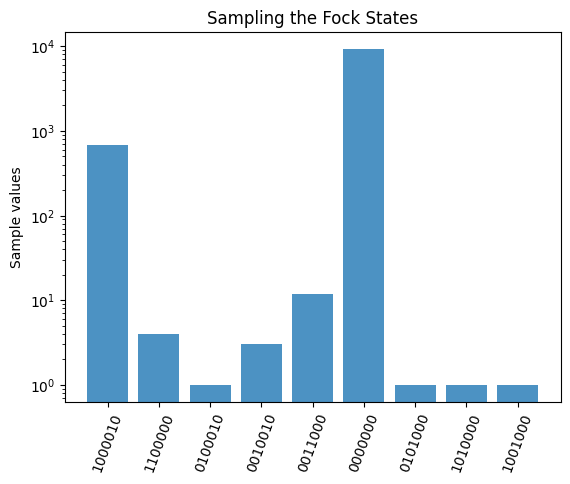

In [51]:
plot_samples(data[2][1]) # plot the samples for (j,n) = 1,6, i.e. the configuration which contains both a physical and minimum-energy solution


In [16]:
def alpha_graph(graph):
    """calculate alpha as sum of all the costs + 1"""
    alpha = 0
    for i in range(0,len(graph)):
        for j in range(0,len(graph)):
            if graph[i][j] != 0 : alpha+=graph[i][j]
    return alpha+1

def graph_to_s(graph, s, weight):
    """calculate Hs"""
    ham = np.zeros((weight, weight))
    edges_coeff = [0]*weight
    constant_coeff = -1
    count = 0
    for i in range(0, len(graph)):
        for j in range(0, len(graph)):
            if graph[i][j] != 0 :
                if i == s:
                    edges_coeff[count] = 1
                if j == s:
                    edges_coeff[count] = -1
                count += 1

    for i in range(0, weight):
        for j in range(i+1, weight):
            ham[i][j] = edges_coeff[i]*edges_coeff[j]*2

    for i in range(0, weight):
        ham[i][i] += edges_coeff[i]*edges_coeff[i] + constant_coeff*edges_coeff[i]*2

    return ham

def graph_to_f(graph, t, weight):
    """calculate Hf"""
    ham = np.zeros((weight, weight))
    edges_coeff = [0]*weight
    constant_coeff = +1
    count = 0
    for i in range(0,len(graph)):
        for j in range(0,len(graph)):
            if graph[i][j] != 0 :
                if i == t:
                    edges_coeff[count] = 1
                if j == t:
                    edges_coeff[count] = -1
                count += 1

    for i in range(0, weight):
        for j in range(i+1, weight):
            ham[i][j] = edges_coeff[i]*edges_coeff[j]*2

    for i in range(0,weight):
        ham[i][i] += edges_coeff[i]*edges_coeff[i] + constant_coeff*edges_coeff[i]*2

    return ham

def graph_to_i(graph, our_i, weight):
    """calculate Hi"""
    ham = np.zeros((weight, weight))
    edges_coeff = [0]*weight
    count = 0
    for i in range(0, len(graph)):
        for j in range(0, len(graph)):
            if graph[i][j] != 0 :
                if i==our_i:
                    edges_coeff[count] = 1
                if j==our_i:
                    edges_coeff[count] = -1
                count += 1

    for i in range(0, weight):
        for j in range(i+1, weight):
            ham[i][j] = edges_coeff[i]*edges_coeff[j]*2

    for i in range(0, weight):
        ham[i][i] += edges_coeff[i]*edges_coeff[i]

    return ham

def graph_to_c(graph, weight):
    """calculate Hc"""
    ham = np.zeros((weight, weight))
    count = 0
    for i in range(0,len(graph)):
        for j in range(0,len(graph)):
            if graph[i][j] != 0 :
                ham[count][count] = graph[i][j]
                count += 1

    return ham

def graph_to_hamiltonian(graph,s,f):
    """returns the graph adjacency matrix as a Hamiltonian"""
    weight = np.count_nonzero(graph)
    ham =  np.zeros((weight, weight))
    alpha = alpha_graph(graph)
    ham += alpha*graph_to_s(graph, s, weight)
    ham += alpha*graph_to_f(graph, f, weight)
    for i in range(0,weight):
        if i!=s and i!=f:
            ham += alpha*graph_to_i(graph, i, weight)
    ham += graph_to_c(graph, weight)

    return ham

In [10]:
"""example: our 5-edge graph"""
# start,a,b,finish -> 0,1,2,3
#G1 = np.array([[0,2,1,0,0,0], [0,0,2,3,0,5], [0,2,0,1,2,0], [0,0,0,0,3,1], [0,0,0,0,0,4], [0,0,0,0,0,0]]) # weights associated to all possible paths
G1_s = 0 # start index
G1_f = 3 # finish index
H_example = graph_to_hamiltonian(G1, G1_s, G1_f)
print(H_example)

[[   2.   54.  -54.  -54.  -54.   54.    0.    0.    0.    0.    0.]
 [   0.    1.   54.    0.    0.  -54.  -54.  -54.    0.    0.    0.]
 [   0.    0.   56.   54.   54. -108.  -54.  -54.    0.    0.    0.]
 [   0.    0.    0.    3.   54.  -54.   54.    0.  -54.  -54.    0.]
 [   0.    0.    0.    0.   59.  -54.    0.    0.    0.   54.   54.]
 [   0.    0.    0.    0.    0.   56.   54.   54.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    1.   54.  -54.  -54.    0.]
 [   0.    0.    0.    0.    0.    0.    0.   56.   54.    0.  -54.]
 [   0.    0.    0.    0.    0.    0.    0.    0.  111.   54.  -54.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.  109.   54.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   58.]]
